# Health Insurance Final Project

#### Manna Sirak

About the data:

Payments .csv files - year, type, group, payment<br>
Coverage modifications per group .csv file - group, deductible, coinsurance, policy limit<br>
Diseases per person .csv file - subject, number of claims

**Data Dictionary**

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| year | Year                                   | 2015, 2016, 2017, 2018                                |
| type   | Type of disease                               | 1 = Acute, 2 = Subacute, 3 = Chronic                      |
| group      | Insurance group                                        |1 = I, 2 = II, 3 = III, 4 = IV, 5 = V                                                |
| payment      | Payment made to insurance company for single claim                              |                                                |
| deductible    | Insurance plan deductible |                                                |
| coinsurance    | Percentage insured pays after deductible reached |                                                |
| policy limit   | Maximum amt insurance company will pay per claim                             |                                                |
| 


***Key differences between analysis at presentation and final analysis: in presentation, had 2 dependent variables: insurance payout and total claim (insurance payout by company + amount paid by insured). Here, narrowed that down to 1 dependent var, total claim, because it was the more interesting of the two to me. I also cut out outliers in this final version, which resulted in altered figures from those in the powerpoint, and will be explored further below.***

# Data Cleaning & Prep

Import core libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import and merge datasets

In [4]:
d_2015 = pd.read_csv('Payments 2015.csv')
d_2016 = pd.read_csv('Payments 2016.csv')
d_2017 = pd.read_csv('Payments 2017.csv')
d_2018 = pd.read_csv('Payments 2018.csv')
cov_mod = pd.read_csv('Coverage modifications per group.csv')

,Year,Type,Group,Payment,Deductible,Coinsurance,Policy limit
0,2015,Subaguda,I,"$1,079","$5,000.00",5%,"$200,000.00"
1,2015,Subaguda,I,"$25,557","$5,000.00",5%,"$200,000.00"
2,2015,Accidente,I,"$27,475","$5,000.00",5%,"$200,000.00"


In [6]:
d_2018.Type.unique()

array(['Accidente', 'Subaguda', 'Crítica', 'Aguda'], dtype=object)

In [7]:
merge = [d_2015, d_2016, d_2017, d_2018]
payments = pd.concat(merge)
len(payments)

1447

In [8]:
paydata = pd.merge(payments, cov_mod, on='Group')
paydata.head(3)

,Year,Type,Group,Payment,Deductible,Coinsurance,Policy limit
0,2015,Subaguda,I,"$1,079","$5,000.00",5%,"$200,000.00"
1,2015,Subaguda,I,"$25,557","$5,000.00",5%,"$200,000.00"
2,2015,Accidente,I,"$27,475","$5,000.00",5%,"$200,000.00"


## Transforming and creating variables

Strip non-numeric characters from numeric variables

In [11]:
# strip using for loops and adding to lists

payment = []
deductible = []
coinsurance = []
policy_limit = []

for p in paydata['Payment']:
    payment.append(p.strip('$').replace(',',''))

for d in paydata['Deductible']:
    deductible.append(d.strip('$').replace(',',''))
    
for c in paydata['Coinsurance']:
    coinsurance.append(c.strip('%'))
        
for pl in paydata['Policy limit']:
    policy_limit.append(pl.strip('$').replace(',',''))

In [12]:
# compile lists into a dataframe called cols_to_insert

to_insert = {'Payment':payment, 'Deductible':deductible, 'Coinsurance':coinsurance,
             'Policy limit':policy_limit}
cols_to_insert = pd.DataFrame (to_insert, columns = ['Payment', 'Deductible','Coinsurance','Policy limit'])
cols_to_insert.head(3)

,Payment,Deductible,Coinsurance,Policy limit
0,1079,5000.00,5,200000.00
1,25557,5000.00,5,200000.00
2,27475,5000.00,5,200000.00


In [13]:
# change data types to all integers, and adjust coinsurance percentage to float value

cols_to_insert = cols_to_insert.astype({'Payment':int, 'Deductible':float,'Coinsurance':float,'Policy limit':float})
cols_to_insert['Coinsurance'] = cols_to_insert['Coinsurance'].div(100)

cols_to_insert.head(3)

,Payment,Deductible,Coinsurance,Policy limit
0,1079,5000.0,0.05,200000.0
1,25557,5000.0,0.05,200000.0
2,27475,5000.0,0.05,200000.0


Calculate total claim amount:

total_claim = amt paid by insurer + amt paid by insured <br>
total_claim = payment + deductible + (((100 x payment) / 95)*.05)

In [14]:
# calculate total claim amount and add as column into cols_to_insert
    # 1. calculate amount insured paid after deductible, add as column to cols_to_insert
    # 2. calculate total claim in separate column as sum of payment, deductible, and amt 
        # insured paid after deductible
    
insured_paid_post_deduct = []
for l in cols_to_insert['Payment']:
    x = (l*(100/95))*.05
    insured_paid_post_deduct.append(round(x, 2))

to_insert1 = {'Post ded payment insured':insured_paid_post_deduct}
cols_to_insert['Post ded payment insured'] = to_insert1['Post ded payment insured']


cols_to_insert['Total claim'] = cols_to_insert['Payment']+cols_to_insert['Deductible']+cols_to_insert['Post ded payment insured']
cols_to_insert.head(3)

,Payment,Deductible,Coinsurance,Policy limit,Post ded payment insured,Total claim
0,1079,5000.0,0.05,200000.0,56.79,6135.79
1,25557,5000.0,0.05,200000.0,1345.11,31902.11
2,27475,5000.0,0.05,200000.0,1446.05,33921.05


Replace old columns in paydata with reformatted ones from cols_to_insert

In [15]:
paydata['Payment'] = cols_to_insert['Payment']
paydata['Deductible'] = cols_to_insert['Deductible']
paydata['Coinsurance'] = cols_to_insert['Coinsurance']
paydata['Policy limit'] = cols_to_insert['Policy limit']
paydata['Total claim'] = cols_to_insert['Total claim']
paydata.head(10)

,Year,Type,Group,Payment,Deductible,Coinsurance,Policy limit,Total claim
0,2015,Subaguda,I,1079,5000.0,0.05,200000.0,6135.79
1,2015,Subaguda,I,25557,5000.0,0.05,200000.0,31902.11
2,2015,Accidente,I,27475,5000.0,0.05,200000.0,33921.05
3,2015,Accidente,I,23748,5000.0,0.05,200000.0,29997.89
4,2015,Accidente,I,16071,5000.0,0.05,200000.0,21916.84
5,2015,Accidente,I,3196,5000.0,0.05,200000.0,8364.21
6,2015,Subaguda,I,20711,5000.0,0.05,200000.0,26801.05
7,2015,Subaguda,I,13499,5000.0,0.05,200000.0,19209.47
8,2015,Accidente,I,869,5000.0,0.05,200000.0,5914.74
9,2015,Crítica,I,200000,5000.0,0.05,200000.0,215526.32


Translate Spanish to English

In [32]:
paydata['Type'] = paydata['Type'].replace(['Subaguda','Aguda','Crítica','Accidente'],['Subacute','Acute','Chronic','Accidental'])
paydata.head(10)

,Year,Type,Group,Payment,Deductible,Coinsurance,Policy limit,Total claim
0,2015,Subacute,I,1079,5000.0,0.05,200000.0,6135.79
1,2015,Subacute,I,25557,5000.0,0.05,200000.0,31902.11
2,2015,Accidental,I,27475,5000.0,0.05,200000.0,33921.05
3,2015,Accidental,I,23748,5000.0,0.05,200000.0,29997.89
4,2015,Accidental,I,16071,5000.0,0.05,200000.0,21916.84
5,2015,Accidental,I,3196,5000.0,0.05,200000.0,8364.21
6,2015,Subacute,I,20711,5000.0,0.05,200000.0,26801.05
7,2015,Subacute,I,13499,5000.0,0.05,200000.0,19209.47
8,2015,Accidental,I,869,5000.0,0.05,200000.0,5914.74
9,2015,Chronic,I,200000,5000.0,0.05,200000.0,215526.32


## Dealing with missing data and outliers

### Missing data

In [33]:
missing_d = np.where(paydata.isna())

missing_data = np.shape(missing_d)[0] * np.shape(missing_d)[1]
all_data = np.shape(paydata)[0] * np.shape(paydata)[1]
print('Missing entries: {0} of {1} ({2:.0f}%)'.format(missing_data, all_data, missing_data/all_data*100))

Missing entries: 0 of 11576 (0%)


### Outliers

***In presentation, didn't deal with outliers. Suggested that I would deal with them at the 75% level (1.5 st devs from mean) - here accounted for those more than 2 st devs from mean***

Produce boxplot

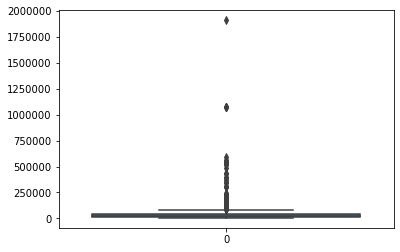

In [34]:
sns.boxplot(data=paydata['Total claim'])

In [35]:
# remove claims (rows) with total claim values farther than 2 st dev from mean
# assign to new var, paydatao

q = paydata['Total claim'].quantile(0.9544)
paydatao = paydata[paydata['Total claim'] < q]
paydatao

,Year,Type,Group,Payment,Deductible,Coinsurance,Policy limit,Total claim
0,2015,Subacute,I,1079,5000.0,0.05,200000.0,6135.79
1,2015,Subacute,I,25557,5000.0,0.05,200000.0,31902.11
2,2015,Accidental,I,27475,5000.0,0.05,200000.0,33921.05
3,2015,Accidental,I,23748,5000.0,0.05,200000.0,29997.89
4,2015,Accidental,I,16071,5000.0,0.05,200000.0,21916.84
...,...,...,...,...,...,...,...,...
1437,2018,Accidental,III,26171,20000.0,0.10,1000000.0,47548.42
1439,2018,Subacute,III,4428,20000.0,0.10,1000000.0,24661.05
1440,2015,Subacute,IV,41256,30000.0,0.10,10000000.0,73427.37
1443,2018,Chronic,IV,21649,30000.0,0.10,10000000.0,52788.42


# Exploratory Data Analysis

## Descriptives

In [36]:
# counts of # claims in each group

paydatao.groupby('Group').size().reset_index()

,Group,0
0,I,1104
1,II,178
2,III,40
3,IV,3


In [37]:
# check distribution of numeric features

distr = paydatao.describe().apply(lambda x: x.apply('{0:.2f}'.format))
distr

,Year,Payment,Deductible,Coinsurance,Policy limit,Total claim
count,1325.00,1325.00,1325.00,1325.00,1325.00,1325.00
mean,2016.49,20121.15,6181.13,0.05,286641.51,27361.29
std,1.10,27592.19,3190.40,0.01,491463.04,29370.86
min,2015.00,25.00,5000.00,0.05,200000.00,5026.32
25%,2016.00,4322.00,5000.00,0.05,200000.00,10194.74
50%,2017.00,10698.00,5000.00,0.05,200000.00,17668.42
75%,2017.00,24917.00,5000.00,0.05,200000.00,33525.26
max,2018.00,191194.00,30000.00,0.10,10000000.00,206256.84


In [204]:
distr[['Total claim']]

,Total claim
count,1325.00
mean,27361.29
std,29370.86
min,5026.32
25%,10194.74
50%,17668.42
75%,33525.26
max,206256.84


In [38]:
# get correlation matrix

corrs = paydatao.corr(method='pearson')
corrs

,Year,Payment,Deductible,Coinsurance,Policy limit,Total claim
Year,1.000000,-0.009786,0.036263,0.015258,0.031541,-0.005738
Payment,-0.009786,1.000000,0.047975,0.014387,0.030002,0.994096
Deductible,0.036263,0.047975,1.000000,0.833628,0.648563,0.156067
Coinsurance,0.015258,0.014387,0.833628,1.000000,0.500009,0.104780
Policy limit,0.031541,0.030002,0.648563,0.500009,1.000000,0.100118
Total claim,-0.005738,0.994096,0.156067,0.104780,0.100118,1.000000


### Grouped means and medians

In [151]:
# Construct total claim mean & med grouped by Group

Go_mean = paydatao.groupby(by='Group').mean().rename(columns={'Total claim': 'Total claim Mean'})
Go_med = paydatao.groupby(by='Group').median().rename(columns={'Total claim': 'Total claim Median'})

Go_Tot_mean_med = pd.concat([Go_mean[['Total claim Mean']], Go_med[['Total claim Median']]], axis=1).apply(lambda x: x.apply('{0:.0f}'.format))


# Construct total claim mean & median grouped by Type

To_mean = paydatao.groupby(by='Type').mean().rename(columns={'Total claim': 'Total claim Mean'})
To_med = paydatao.groupby(by='Type').median().rename(columns={'Total claim': 'Total claim Median'})

To_Tot_mean_med = pd.concat([To_mean[['Total claim Mean']], To_med[['Total claim Median']]], axis=1).apply(lambda x: x.apply('{0:.0f}'.format))

In [152]:
# Total claim mean & med grouped by Group

Go_Tot_mean_med

,Total claim Mean,Total claim Median
Group,,
I,25340,15435
II,35841,26792
III,42966,36173
IV,60055,53951


In [153]:
# Total claim mean & med grouped by Type

To_Tot_mean_med

,Total claim Mean,Total claim Median
Type,,
Accidental,17532,12520
Acute,6903,6511
Chronic,96900,85662
Subacute,31621,27396


In [148]:
# With outliers, for comparison

G_mean = paydata.groupby(by='Group').mean().rename(columns={'Total claim': 'Total claim Mean'})
G_med = paydata.groupby(by='Group').median().rename(columns={'Total claim': 'Total claim Median'})
G_Tot_mean_med = pd.concat([G_mean[['Total claim Mean']], G_med[['Total claim Median']]], axis=1).apply(lambda x: x.apply('{0:.0f}'.format))

T_mean = paydata.groupby(by='Type').mean().rename(columns={'Total claim': 'Total claim Mean'})
T_med = paydata.groupby(by='Type').median().rename(columns={'Total claim': 'Total claim Median'})
T_Tot_mean_med = pd.concat([T_mean[['Total claim Mean']], T_med[['Total claim Median']]], axis=1).apply(lambda x: x.apply('{0:.0f}'.format))

In [149]:
G_Tot_mean_med

,Total claim Mean,Total claim Median
Group,,
I,39380,17376
II,74917,29568
III,172611,40995
IV,508249,306987


In [150]:
T_Tot_mean_med

,Total claim Mean,Total claim Median
Type,,
Accidental,18405,12569
Acute,6903,6511
Chronic,224410,215526
Subacute,31621,27396


Compared to values with outliers, Group IV mean has decreased significantly. Chronic mean and median have also both dropped significantly. This suggests many of the outliers may have belonged to chronic group. 

## Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002477394F828>]],
      dtype=object)

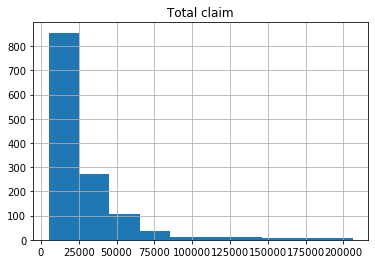

In [49]:
# Total claim (dependent variable) distribution

paydatao.hist(column=['Total claim'])

Total claims data has clear negative binomial distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247758C8CC0>,
      dtype=object)

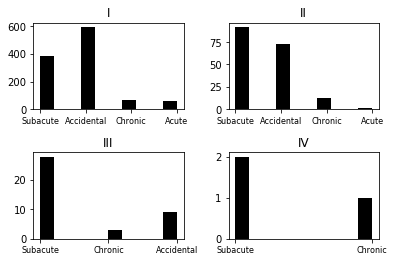

In [205]:
# by Group of coverage

paydatao.hist(by='Group', column='Type', xlabelsize=8, color='black', rot=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247758A7B70>,
      dtype=object)

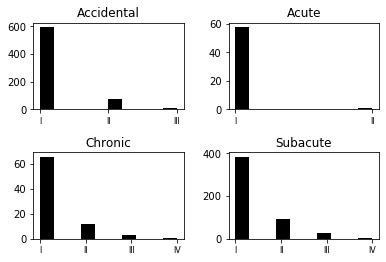

In [206]:
# by Type of claim

paydatao.hist(by='Type', column='Group', xlabelsize=8, color='black', rot=0)

In [193]:
import matplotlib as plt

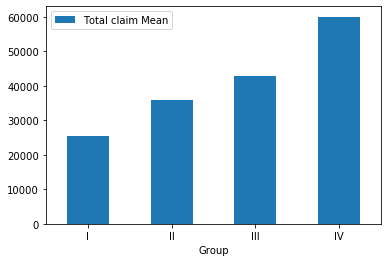

In [198]:
Go_mean = Go_Tot_mean_med['Total claim Mean'].to_frame().astype({'Total claim Mean':int})
Go_mean.plot.bar(rot=0)

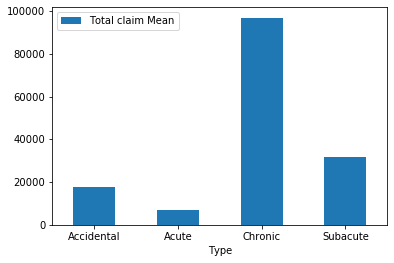

In [215]:
To_mean = To_Tot_mean_med['Total claim Mean'].to_frame().astype({'Total claim Mean':int})
To_mean.plot.bar(rot=0)

Create dummy variables for all categorical variables: Year, Group, Type

In [40]:
paydataod = pd.get_dummies(paydatao, columns=['Year','Type','Group'], drop_first=True)
paydataod.head(3)

,Payment,Deductible,Coinsurance,Policy limit,Total claim,Year_2016,Year_2017,Year_2018,Type_Acute,Type_Chronic,Type_Subacute,Group_II,Group_III,Group_IV
0,1079,5000.0,0.05,200000.0,6135.79,0,0,0,0,0,1,0,0,0
1,25557,5000.0,0.05,200000.0,31902.11,0,0,0,0,0,1,0,0,0
2,27475,5000.0,0.05,200000.0,33921.05,0,0,0,0,0,0,0,0,0


# Modeling

Import relevant libraries

In [116]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Defining X and Y

In [72]:
# X: all Years, all Types, all Groups (policy info implicit to group)
# Y: Total claim

X = paydataod.drop(['Payment','Deductible','Coinsurance','Policy limit','Total claim'], axis=1)
Y = paydataod.filter(['Total claim'])

Train and test split - test 20%

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [75]:
# check shapes

print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of X_test: {}'.format(X_test.shape))
print('Shape of Y_train: {}'.format(Y_train.shape))
print('Shape of Y_test: {}'.format(Y_test.shape))

Shape of X_train: (1060, 9)
Shape of X_test: (265, 9)
Shape of Y_train: (1060, 1)
Shape of Y_test: (265, 1)


In [ ]:
# drop na's

things = [X_train, X_test, Y_train, Y_test]
for i in things:
    i = i.dropna(inplace=True)

## Linear Regression

Create and run linear model, create predictions

In [92]:
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

Produce coefficients and measures of model fit

In [103]:
print('Linear Regression Model Fit:')
print('\n')
print('Coefficients: ', lr.coef_)
print('MSE: %.3f' %mean_squared_error(Y_test, lr_pred))
print('RMSE: %.3f' %mean_squared_error(Y_test, lr_pred, squared=False))
print('R squared: %.3f' %r2_score(Y_test, lr_pred))

Linear Regression Model Fit:


Coefficients:  [[ -447.52497146  1164.4495983   -666.26597072 -9583.93054242
  78227.89129566 12598.20728666  7586.73955625  9063.9981241
   9587.24388416]]
MSE: 624240614.618
RMSE: 24984.808
R squared: 0.425


In [138]:
coefs_lr = lr.coef_[0]
c = coefs_lr.tolist()
coeffs_lr = pd.DataFrame({
    'attribute': X.columns,
    'coefficient': c
})

coeffs_lr

,attribute,coefficient
0,Year_2016,-447.524971
1,Year_2017,1164.449598
2,Year_2018,-666.265971
3,Type_Acute,-9583.930542
4,Type_Chronic,78227.891296
5,Type_Subacute,12598.207287
6,Group_II,7586.739556
7,Group_III,9063.998124
8,Group_IV,9587.243884


Very large coeffients, both positive and negative. May be due to multicollinearity. R^2 value indicates that model explains less than half of variation in Total claim.

## Random Forest

Create and run random forest model, create predictions

In [94]:
rf = RandomForestRegressor(n_estimators=1000, random_state=123)
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)

c:\users\manna\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Produce coefficients and measures of model fit

In [115]:
print('Random Forest Model Fit:')
print('\n')
print('MSE: %.3f' %mean_squared_error(Y_test, rf_pred))
print('RMSE: %.3f' %mean_squared_error(Y_test, rf_pred, squared=False))
print('R squared: %.3f' %r2_score(Y_test, rf_pred))

Random Forest Model Fit:


MSE: 666026082.896
RMSE: 25807.481
R squared: 0.386


Random forest has a lower R^2 and slightly higher error than linear model.  

## Only group 1

Defining base group and corresponding X and Y values

In [140]:
# create base group and dummies

paydatao1 = paydatao[paydatao['Group']=='I']
paydataod1 = pd.get_dummies(paydatao1, columns=['Year','Type','Group'], drop_first=True)

# create X and Y for group 1 

X1 = paydataod1.drop(['Payment','Deductible','Coinsurance','Policy limit','Total claim'], axis=1)
Y1 = paydataod1.filter(['Total claim'])

Train and test split - 20%

In [141]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=123)

In [142]:
# drop na's

things = [X1_train, X1_test, Y1_train, Y1_test]
for i in things:
    i = i.dropna(inplace=True)

c:\users\manna\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Linear Regression

In [143]:
lr1 = linear_model.LinearRegression()
lr1.fit(X1_train, Y1_train)
lr1_pred = lr1.predict(X1_test)

print('Linear Regression Model Fit - Group 1:')
print('\n')
print('Coefficients: ', lr1.coef_)
print('MSE: %.3f' %mean_squared_error(Y1_test, lr1_pred))
print('RMSE: %.3f' %mean_squared_error(Y1_test, lr1_pred, squared=False))
print('R squared: %.3f' %r2_score(Y1_test, lr1_pred))

Linear Regression Model Fit - Group 1:


Coefficients:  [[ -276.37751116  2557.4929074   1131.55976    -9475.112922
  83863.62079779 12969.30440522]]
MSE: 523485835.387
RMSE: 22879.813
R squared: 0.285


Random Forest Regression

In [144]:
rf1 = RandomForestRegressor(n_estimators=1000, random_state=123)
rf1.fit(X1_train, Y1_train)
rf1_pred = rf1.predict(X1_test)

print('Random Forest Model Fit - Group 1:')
print('\n')
print('MSE: %.3f' %mean_squared_error(Y1_test, rf1_pred))
print('RMSE: %.3f' %mean_squared_error(Y1_test, rf1_pred, squared=False))
print('R squared: %.3f' %r2_score(Y1_test, rf1_pred))

c:\users\manna\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Model Fit - Group 1:


MSE: 527395010.142
RMSE: 22965.082
R squared: 0.280
